In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
from tqdm.notebook import tqdm
import sympy as sp

from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

# hp-VPINNs: Two-dimensional Poisson's equation

Let $u(x,y):\Omega \rightarrow \mathbb{R}$, where $\Omega =[0,2]\times [0,2]$. We consider the problem 


\begin{align}
\Delta u(x,y) &= f(x,y) \\
u(x,y) &= h(x,y), \,\,\,\,\, (x,y) \in \partial \Omega. 
\end{align}

Let the approximate solution $u(x,y) \approx u_{NN}(x,y)$. Then, the strong-form residual is:

\begin{align}
r(x,y) &= \Delta u_{NN}(x,y) - f(x,y)  \tag{3}\\
r_b(x,y) &= u_{NN}(x,y) - h(x,y), \,\,\,\, (x,y) \in \partial\Omega. \tag{4}
\end{align}

We divide the domain $\Omega$ into non-overlaping elements $\Omega_{e_xe_y} = [x_{e_x-1}, x_{e_x}]\times [x_{e_y-1}, x_{e_y}]$. We choose a set of localized non-overlaping test functions $\overline{v}_{k_1k_2}(x,y)$ with nonvanishing function to be the high-order polynomial such that:

$$\overline{v}_{k_1k_2}(x,y) = \overline{v}_{k_1}(x)\overline{v}_{k_2}(y), $$

where $\overline{v}_k(x) = v_k(g^{-1}(x)) = P_{k-1}(g^{-1}(x))-P_{k}(g^{-1}(x))$, with $g$ a function from $[x_{e_x-1}, x_{e_x}]$ to $[-1,1]$, and  $P_k$ is Legendre polynomial of order $k$. The variational residual becomes

$$\mathcal{R}_{k_1k_2} = \sum_{e_x = 1}^{N_{el_x}}\sum_{e_y = 1}^{N_{el_y}} \mathcal{R}_{k_1k_2}^{(e_xe_y)}, \tag{5} $$

$$ \mathcal{R}_{k_1k_2}^{(e_xe_y)} = \int_{x_{e_x-1}}^{x_{e_x}} \int_{x_{e_y-1}}^{x_{e_y}} \left( \Delta u(x,y) - f(x,y) \right) \overline{v}_{k_1k_2}(x,y)dydx = \int_{x_{e_x-1}}^{x_{e_x}} \int_{x_{e_y-1}}^{x_{e_y}} \left( \Delta u(x,y) - f(x,y) \right) \overline{v}_{k_1}^{(e_x)}(x)\overline{v}_{k_2}^{(e_y)}(y)dydx. \tag{6}$$

The variational forms by integrating by parts the first term of $\mathcal{R}_{k_1k_2}^{(e_xe_y)}$

$$\mathcal{R}_{k_1k_2}^{(e_xe_y)} = - \int_{x_{e_x-1}}^{x_{e_x}} \int_{x_{e_y-1}}^{x_{e_y}} \nabla u(x,y) \nabla \overline{v}_{k_1k_2}(x,y)dydx +  \nabla u(x,y) \overline{v}_{k_1k_2}(x,y)\Bigg|_{\partial \Omega} -  \int_{x_{e_x-1}}^{x_{e_x}} \int_{x_{e_y-1}}^{x_{e_y}} f(x,y) \overline{v}_{k_1k_2}(x,y)dydx.\tag{7}$$

The second term of (7) vanish. The corresponding variational loss function take the form

$$\mathcal{L} = \sum_{e_x=1}^{N_{el_x}}\sum_{e_y=1}^{N_{el_y}}\dfrac{1}{K_1 K_2}\sum_{k = 1}^{K_1 K_2} \left| \mathcal{R}_{k}^{(e_xe_y)} \right|^2 + \tau_b \,\dfrac{1}{N_b} \sum_{i=1}^{N_b}\left| r_b(x_b^{i}, y_b^{i})\right|^2, \tag{8}$$
where $K_1K_2$ is the number of test function in element $e_xe_y$.

# Code

In [2]:
# Legendre Polynomial   
def Test_fcn_x(n,x):
       test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
       return test

def Test_fcn_y(n,y):
    test  = Jacobi(n+1,0,0,y) - Jacobi(n-1,0,0,y)
    return test

In [3]:
# Cálculo de Laplaciano
x, y = sp.symbols('x y')
u = 6*x*y*(x-2)*(y-2)

d2u_dx2 = sp.diff(u, x, x)  # Segunda derivada con respecto a x
d2u_dy2 = sp.diff(u, y, y)  # Segunda derivada con respecto a y

laplacian = d2u_dx2 + d2u_dy2  # Laplaciano
print(f'Laplaciano: {laplacian}')


Laplaciano: 12*x*(x - 2) + 12*y*(y - 2)


In [4]:
# Real Solution 
def u_ext(x, y):
    utemp =  6*x*y*(x-2)*(y-2)
    return utemp

# Right-hand side function
def f_ext(x,y):
    gtemp = 12*x*(x-2) + 12*y*(y-2)
    return gtemp

In [5]:
# Boundary points
N_bound = 80

x_up = 2*lhs(1,N_bound)
y_up = np.empty(len(x_up))[:,None]
y_up.fill(2)
b_up = np.empty(len(x_up))[:,None]
b_up = u_ext(x_up, y_up)
x_up_train = np.hstack((x_up, y_up))
u_up_train = b_up

x_lo = 2*lhs(1,N_bound)
y_lo = np.empty(len(x_lo))[:,None]
y_lo.fill(0)
b_lo = np.empty(len(x_lo))[:,None]
b_lo = u_ext(x_lo, y_lo)
x_lo_train = np.hstack((x_lo, y_lo))
u_lo_train = b_lo

y_ri = 2*lhs(1,N_bound)
x_ri = np.empty(len(y_ri))[:,None]
x_ri.fill(2)
b_ri = np.empty(len(y_ri))[:,None]
b_ri = u_ext(x_ri, y_ri)
x_ri_train = np.hstack((x_ri, y_ri))
u_ri_train = b_ri    

y_le = 2*lhs(1,N_bound)
x_le = np.empty(len(y_le))[:,None]
x_le.fill(0)
b_le = np.empty(len(y_le))[:,None]
b_le = u_ext(x_le, y_le)
x_le_train = np.hstack((x_le, y_le))
u_le_train = b_le    

X_u_train = np.concatenate((x_up_train, x_lo_train, x_ri_train, x_le_train))
u_train = np.concatenate((u_up_train, u_lo_train, u_ri_train, u_le_train))

In [6]:
# Construction of RHS for VPINNs
N_el_x = 2
N_el_y = 2

NE_x, NE_y = (N_el_x, N_el_y)
[x_l, x_r] = [0, 2]
[y_b, y_t] = [0, 2]
delta_x = (x_r-x_l)/NE_x
delta_y = (y_t-y_b)/NE_y
grid_x = np.asarray([x_l + i*delta_x for i in range(NE_x+1)])
grid_y = np.asarray([y_b + i*delta_y for i in range(NE_y+1)])

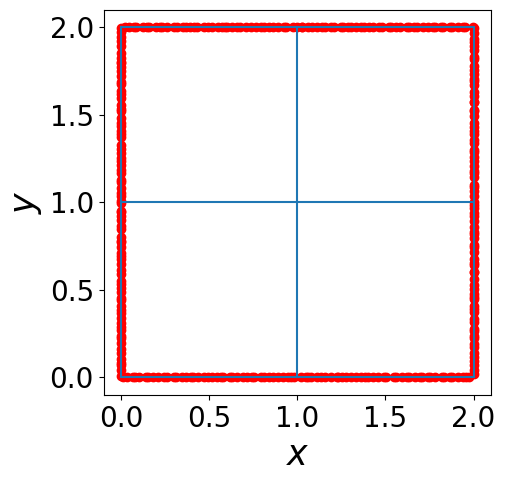

In [7]:
fontsize = 25
x_train_plot, y_train_plot = zip(*X_u_train)
#x_f_plot, y_f_plot = zip(*X_f_train)
fig, ax = plt.subplots(1)

plt.scatter(x_train_plot, y_train_plot, color='red')
for xc in grid_x:
    plt.axvline(x=xc, ymin=0.045, ymax=0.954, linewidth=1.5)
for yc in grid_y:
    plt.axhline(y=yc, xmin=0.045, xmax=0.954, linewidth=1.5)
plt.xlim([-0.1,2.1])
plt.ylim([-0.1,2.1])
plt.xlabel('$x$', fontsize = fontsize)
plt.ylabel('$y$', fontsize = fontsize)
#ax.set_aspect(1)
ax.locator_params(nbins=5)
plt.tick_params( labelsize = 20)
#fig.tight_layout()
fig.set_size_inches(w=5,h=5)

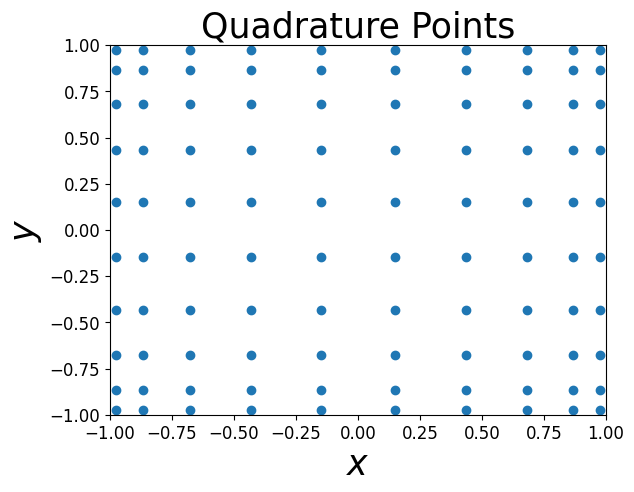

In [8]:
# Quadrature Points
N_quad = 10

[X_quad, WX_quad] = GaussJacobiWeights(N_quad, 0, 0)
Y_quad, WY_quad = (X_quad, WX_quad)
xx, yy = np.meshgrid(X_quad, Y_quad)
wxx, wyy = np.meshgrid(WX_quad, WY_quad)
XY_quad_train = np.hstack((xx.flatten()[:,None], yy.flatten()[:,None]))
WXY_quad_train = np.hstack((wxx.flatten()[:,None], wyy.flatten()[:,None]))

# Test points
plt.scatter(xx.flatten()[:,None], yy.flatten()[:,None])
plt.xlabel('$x$', fontsize = fontsize)
plt.ylabel('$y$', fontsize = fontsize)
plt.title('Quadrature Points', fontsize = fontsize)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tick_params( labelsize = 12)
plt.show()

# 1. $\int f\,\, v_k$

Let $x=g(u)$ be a linear function that takes the interval $[-1,1]$ into the interval $[a,b]$. In particular 
$$x= g(u) = \dfrac{b-a}{2}\,u + \dfrac{b+a}{2}.$$ 
Also, let $v(x)$ be a function with compact support on the interval $[-1,1]$ (Legendre polynomial) and $v_k(x)$ a function defined on the interval $[a,b]$, where $\overline{v}_k(x) := v_k(g^{-1}(x))$.

On the other hand, let $y=h(v)$ be a linear function that takes the interval $[-1,1]$ into the interval $[c,d]$. In particular 
$$y= h(v) = \dfrac{d-c}{2}\,u + \dfrac{d+c}{2}.$$ 

Then 
\begin{align}
\int_{a}^{b}\int_{c}^{d}f(x,y)\overline{v}_{k_1}(x)\overline{v}_{k_2}(y)dydx &= \int_{a}^{b}\int_{c}^{d}f(x,y)v_{k_1}(g^{-1}(x))v_{k_2}(h^{-1}(y))dydx \\
&=  \int_{-1}^{1}\int_{-1}^{1}f(g(u),h(v))v_{k_1}(g^{-1}(g(u)))v_{k_2}(h^{-1}(h(v)))\dfrac{dh}{dv}\dfrac{dg}{du}dvdu\\
&=  \int_{-1}^{1}\int_{-1}^{1}f(g(u),h(v))v_{k_1}(u)v_{k_2}(v)\dfrac{dh}{dv}\dfrac{dg}{du}dvdu\\
&= \dfrac{b-a}{2}\,\dfrac{d-c}{2}\int_{-1}^{1}\int_{-1}^{1}f(h(u),h(v))v_{k_1}(u)v_{k_2}(v)dvdu\\
&\approx \dfrac{b-a}{2}\,\dfrac{d-c}{2}\sum_{i=1}^{N_{quad}}\sum_{j=1}^{N_{quad}}w_i\, z_j f(g(u_i),h(v_j))v_{k_1}(u_i)v_{k_2}(v_j),
\end{align}

where $k_1,k_2$ is the grade of Legendre Polynomial.

In [9]:
N_test_x = N_el_x*[5]
N_test_y = N_el_y*[5]
N_testfcn_total = [N_test_x, N_test_y]

x_quad = XY_quad_train[:,0:1]
y_quad = XY_quad_train[:,1:2]
w_quad = WXY_quad_train

F_ext_total = []

for ex in range(NE_x):
    for ey in range(NE_y):
        Ntest_elementx = N_testfcn_total[0][ex]
        Ntest_elementy = N_testfcn_total[1][ey]
        x_quad_element = (grid_x[ex+1]+grid_x[ex])/2 + (grid_x[ex+1]-grid_x[ex])/2*x_quad
        y_quad_element = (grid_y[ey+1]+grid_y[ey])/2 + (grid_y[ey+1]-grid_y[ey])/2*y_quad
        jacobian = (grid_x[ex+1]-grid_x[ex])*(grid_y[ey+1]-grid_y[ey])/4

        testx_quad_element = np.asarray([Test_fcn_x(n,x_quad) for n in range(1, Ntest_elementx+1)])
        testy_quad_element = np.asarray([Test_fcn_y(n,y_quad) for n in range(1, Ntest_elementy+1)])

        f_quad_element = f_ext(x_quad_element, y_quad_element)

        # F_ext_element = np.asarray([jacobian * sum(w_quad[:,0:1]*testx_quad_element[r]*w_quad[:,1:2]*testy_quad_element[k]*f_quad_element) \
        #                              for r in range(Ntest_elementx) for k in range(Ntest_elementy)])
        F_ext_element = np.asarray([jacobian * sum(w_quad[:,0:1]*testx_quad_element[r]*w_quad[:,1:2]*testy_quad_element[k]*f_quad_element) \
                                    for k in range(Ntest_elementy) for r in range(Ntest_elementx)  ])
        
        F_ext_total.append(F_ext_element)

In [10]:
F_ext_total = np.reshape(F_ext_total, [NE_x, NE_y, N_test_y[0]*N_test_x[0]])

In [11]:
F_ext_total.shape

(2, 2, 25)

# 2. $\int \nabla u  \cdot \nabla \overline{v}_k$

Consider the same change of variable describe in 1. Then 
\begin{align}
\int_{a}^{b}\int_{c}^{d}\nabla u(x,y) \cdot \nabla (\overline{v}_{k_1}(x)\overline{v}_{k_2}(y))dydx &= \int_{a}^{b}\int_{c}^{d}\left(\dfrac{\partial u(x,y)}{\partial x} \dfrac{\partial}{\partial x}\left(v_{k_1}(g^{-1}(x))v_{k_2}(h^{-1}(y))\right) + \dfrac{\partial u(x,y)}{\partial y} \dfrac{\partial}{\partial y}\left(v_{k_1}(g^{-1}(x))v_{k_2}(h^{-1}(y))\right)\right)dydx \\
&= \int_{a}^{b}\int_{c}^{d}\left(\dfrac{\partial u(x,y)}{\partial x} \dfrac{\partial}{\partial x}\left(v_{k_1}(g^{-1}(x))\right)v_{k_2}(h^{-1}(y)) + \dfrac{\partial u(x,y)}{\partial y} v_{k_1}(g^{-1}(x))\dfrac{\partial}{\partial y}\left(v_{k_2}(h^{-1}(y))\right)\right)dydx \\
&= \int_{a}^{b}\int_{c}^{d}\left(\dfrac{\partial u(x,y)}{\partial x} v_{k_1}^{'}(g^{-1}(x))\dfrac{dg^{-1}}{dx}v_{k_2}(h^{-1}(y)) + \dfrac{\partial u(x,y)}{\partial y} v_{k_1}(g^{-1}(x))v_{k_2}^{'}(h^{-1}(y))\dfrac{dh^{-1}}{dy}\right)dydx \\
&= \int_{-1}^{1}\int_{-1}^{1}\left(\dfrac{\partial u(g(u),h(v))}{\partial x} v_{k_1}^{'}(g^{-1}(g(u)))\dfrac{dg^{-1}}{dx}v_{k_2}(h^{-1}(h(v))) + \dfrac{\partial u(g(u),h(v))}{\partial y} v_{k_1}(g^{-1}(g(u)))v_{k_2}^{'}(h^{-1}(h(v)))\dfrac{dh^{-1}}{dy}\right)\dfrac{dh}{dv}\dfrac{dg}{du}dvdu \\
&= \int_{-1}^{1}\int_{-1}^{1}\left(\dfrac{\partial u(g(u),h(v))}{\partial x} v_{k_1}^{'}(u)\dfrac{dg^{-1}}{dx}v_{k_2}(v) + \dfrac{\partial u(g(u),h(v))}{\partial y} v_{k_1}(u)v_{k_2}^{'}(v)\dfrac{dh^{-1}}{dy}\right)\dfrac{dh}{dv}\dfrac{dg}{du}dvdu  \\
&= \int_{-1}^{1}\int_{-1}^{1}\dfrac{\partial u(g(u),h(v))}{\partial x} v_{k_1}^{'}(u)\dfrac{dg^{-1}}{dx}v_{k_2}(v)\dfrac{dh}{dv}\dfrac{dg}{du}dvdu + \int_{-1}^{1}\int_{-1}^{1}\dfrac{\partial u(g(u),h(v))}{\partial y} v_{k_1}(u)v_{k_2}^{'}(v)\dfrac{dh^{-1}}{dy}\dfrac{dh}{dv}\dfrac{dg}{du}dvdu  \\
&= \int_{-1}^{1}\int_{-1}^{1}\dfrac{\partial u(g(u),h(v))}{\partial x} v_{k_1}^{'}(u)v_{k_2}(v)\dfrac{dh}{dv}dvdu + \int_{-1}^{1}\int_{-1}^{1}\dfrac{\partial u(g(u),h(v))}{\partial y} v_{k_1}(u)v_{k_2}^{'}(v)\dfrac{dg}{du}dvdu  \\
&= \dfrac{d-c}{2}\int_{-1}^{1}\int_{-1}^{1}\dfrac{\partial u(g(u),h(v))}{\partial x} v_{k_1}^{'}(u)v_{k_2}(v)dvdu + \dfrac{b-a}{2}\int_{-1}^{1}\int_{-1}^{1}\dfrac{\partial u(g(u),h(v))}{\partial y} v_{k_1}(u)v_{k_2}^{'}(v)dvdu  \\
&\approx \dfrac{d-c}{2}\sum_{i=1}^{N_{quad}}\sum_{j=1}^{N_{quad}}w_i\, z_j \dfrac{\partial u(g(u_i),h(v_j))}{\partial x}v_{k_1}^{'}(u_i)v_{k_2}(v_j) + \dfrac{b-a}{2}\sum_{i=1}^{N_{quad}}\sum_{j=1}^{N_{quad}}w_i\, z_j \dfrac{\partial u(g(u_i),h(v_j))}{\partial y}v_{k_1}(u_i)v_{k_2}^{'}(v_j),
\end{align}

where $k_1,k_2$ is the grade of Legendre Polynomial.

In [12]:
class PINNs(nn.Module):
    def __init__(self, gridx, gridy, F_ext_total, N_testfcn_total, X_u_train, u_train, X_quad, W_quad, input_size = 2, hidden_size = 20,  num_layers = 4, output_size = 1):
        super(PINNs, self).__init__()

        # Feed Forward Neural Network
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            self.hidden_layers.add_module('linear'+str(l), nn.Linear(input_size, hidden_size))
            self.hidden_layers.add_module('tanh'+str(l), nn.Tanh()) 
            input_size = hidden_size
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        self.losses = {'Loss': [],
                       'Loss_BC': [],
                       'Loss_PDE': []}   

        self.N_testfcn_total = N_testfcn_total
        self.N_elementx = np.size(self.N_testfcn_total[0])
        self.N_elementy = np.size(self.N_testfcn_total[1])
        self.Ntestx = self.N_testfcn_total[0][0]
        self.Ntesty = self.N_testfcn_total[1][0]

        self.F_ext_total = torch.tensor(F_ext_total, dtype=torch.float32)

        
        self.gridx = gridx
        self.gridy = gridy

        # Quadrature Points
        self.xquad = X_quad[:,0:1]
        self.yquad = X_quad[:,1:2]
        self.wquad = W_quad
        self.wquad_tensor = torch.tensor(self.wquad, dtype=torch.float32, requires_grad=True)

        # Boundary Points
        self.X_u_train = X_u_train
        self.u_train = u_train
        self.X_u_train_tensor = torch.tensor(self.X_u_train, dtype=torch.float32)
        self.u_train_tensor = torch.tensor(self.u_train, dtype=torch.float32)

        self.weight = 10.0


    # Forward pass
    def forward(self, x, y):
        xy = torch.cat([x,y], dim = 1)
        return self.hidden_layers(xy)
        
    # Derivative of the neural network
    def net_du(self,x, y):
        u = self.forward(x, y)
        d1u_x = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), create_graph=True)[0]
        d1u_y = torch.autograd.grad(u, y, grad_outputs = torch.ones_like(u), create_graph=True)[0]
        return d1u_x, d1u_y
    
    # Test Funcition Legendre Polynomials
    def Test_fcnx(self, n, x):
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        return test
    
    def Test_fcny(self, n,y):
        test = Jacobi(n+1,0,0,y) - Jacobi(n-1,0,0,y)
        return test
    
    # Derivative of Test Function Legendre Polynomials
    def dTest_fcn(self, n, x):
        if n==1:
            d1test = ((n+2)/2)*Jacobi(n,1,1,x)
        elif n==2:
            d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)  
        else:
            d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)   
        return d1test

    #############################################################################################################
    

    def loss_BC(self):
        u_pred = self.forward(self.X_u_train_tensor[:,0:1], self.X_u_train_tensor[:,1:2])
        return torch.mean(torch.square(u_pred - self.u_train_tensor))
    
    def loss_PDE_var(self):
        loss_NN_total = 0.0
        for ex in range(self.N_elementx):
            for ey in range(self.N_elementy):

                Ntest_elementx = self.N_testfcn_total[0][ex]
                Ntest_elementy = self.N_testfcn_total[1][ey] 


                ###############################################################################################################################
                # Gradient of the neural network
                x_quad_element = torch.tensor((self.gridx[ex+1] - self.gridx[ex])/2 * (self.xquad) + (self.gridx[ex+1] + self.gridx[ex])/2, \
                                                dtype=torch.float32, requires_grad=True).view(-1,1)
                
                y_quad_element = torch.tensor((self.gridy[ey+1] - self.gridy[ey])/2 * (self.yquad) + (self.gridy[ey+1] + self.gridy[ey])/2, \
                                                dtype=torch.float32, requires_grad=True).view(-1,1)


                d1xu_NN_quad_element, d1yu_NN_quad_element = self.net_du(x_quad_element, y_quad_element)
                ###############################################################################################################################
                # Jacobian
                jacobian_x = (self.gridx[ex+1]-self.gridx[ex])/2
                jacobian_y = (self.gridy[ey+1]-self.gridy[ey])/2

                # Legendre Polynomials
                testx_quad_element = torch.tensor([self.Test_fcnx(n,self.xquad) for n in range(1, Ntest_elementx+1)], dtype=torch.float32)
                testy_quad_element = torch.tensor([self.Test_fcny(n,self.yquad) for n in range(1, Ntest_elementy+1)], dtype=torch.float32)

                # Derivative of Legendre Polynomials
                d1testx_quad_element = torch.tensor([self.dTest_fcn(n,self.xquad) for n in range(1, Ntest_elementx+1)], dtype=torch.float32)
                d1testy_quad_element = torch.tensor([self.dTest_fcn(n,self.yquad) for n in range(1, Ntest_elementy+1)], dtype=torch.float32)
                ###############################################################################################################################
                

                var_NN_element_1 = torch.stack([
                    torch.stack([ jacobian_y * torch.sum(self.wquad_tensor[:,0:1] * self.wquad_tensor[:,1:2] * d1xu_NN_quad_element * d1testx_quad_element[r] * testy_quad_element[k] )\
                                    for r in range(Ntest_elementx) ]) for k in range(Ntest_elementy)]).view(-1,1)
                
                var_NN_element_2 = torch.stack([
                    torch.stack([ jacobian_x * torch.sum(self.wquad_tensor[:,0:1] * self.wquad_tensor[:,1:2] * d1yu_NN_quad_element * testx_quad_element[r] * d1testy_quad_element[k] )\
                                    for r in range(Ntest_elementx) ]) for k in range(Ntest_elementy)]).view(-1,1)
                
                var_NN_element = - var_NN_element_1 - var_NN_element_2
                
                F_ext_element = self.F_ext_total[ex,ey].view(-1,1)
                Res_NN_element = var_NN_element - F_ext_element
                loss_NN_element = torch.mean(torch.square(Res_NN_element))
                loss_NN_total = loss_NN_element + loss_NN_total
        return loss_NN_total
                 
    
    def loss(self):
        loss_boundary = self.loss_BC()
        loss_PDE = self.loss_PDE_var()
        loss_total = self.weight * loss_boundary + loss_PDE
        return loss_total, loss_boundary, loss_PDE
    
    def train(self, epochs = 1000, lr = 0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs+1)):
            optimizer.zero_grad()
            loss, loss_bc, loss_pde = self.loss()
            loss.backward()
            optimizer.step()
            self.losses['Loss'].append(loss.item())
            self.losses['Loss_BC'].append(loss_bc.item())
            self.losses['Loss_PDE'].append(loss_pde.item())

            if epoch % 1000 == 0:
                print('Epoch {}: Loss {}, loss_bc {}, loss_pde {}'.format(epoch, loss.item(), loss_bc.item(), loss_pde.item()))

In [16]:
model_1 = PINNs(grid_x, grid_y, F_ext_total, N_testfcn_total, X_u_train, u_train, XY_quad_train, WXY_quad_train)

In [17]:
#model_1.loss_PDE_var()

In [18]:
model_1.train(epochs = 20000, lr = 0.001)

  0%|          | 0/20001 [00:00<?, ?it/s]

Epoch 0: Loss 46.58961486816406, loss_bc 0.023020440712571144, loss_pde 46.35940933227539
Epoch 1000: Loss 0.19304460287094116, loss_bc 0.008961145766079426, loss_pde 0.10343314707279205
Epoch 2000: Loss 0.07427118718624115, loss_bc 0.004893637262284756, loss_pde 0.025334808975458145
Epoch 3000: Loss 0.044736433774232864, loss_bc 0.0030694250017404556, loss_pde 0.014042183756828308
Epoch 4000: Loss 0.026924539357423782, loss_bc 0.0018986307550221682, loss_pde 0.007938231341540813
Epoch 5000: Loss 0.01737668737769127, loss_bc 0.001191728631965816, loss_pde 0.005459400825202465
Epoch 6000: Loss 0.012883314862847328, loss_bc 0.0008450740715488791, loss_pde 0.004432573914527893
Epoch 7000: Loss 0.010669338516891003, loss_bc 0.000687324907630682, loss_pde 0.0037960896734148264
Epoch 8000: Loss 0.008794103749096394, loss_bc 0.0005500065162777901, loss_pde 0.003294038586318493
Epoch 9000: Loss 0.009737870655953884, loss_bc 0.00068228057352826, loss_pde 0.002915065037086606
Epoch 10000: Loss 0

# Result

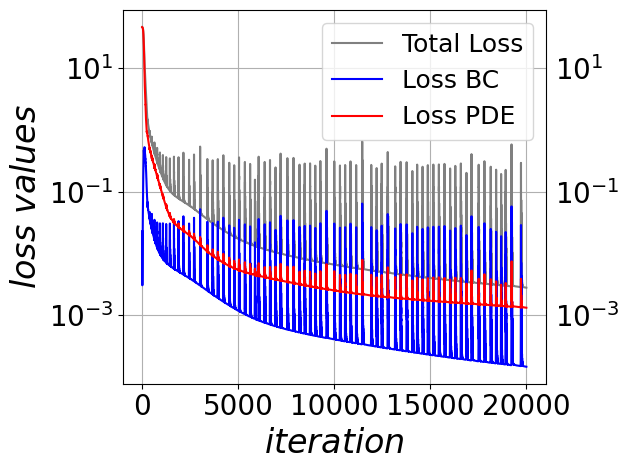

In [19]:
fontsize = 24
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = fontsize)
plt.ylabel('$loss \,\, values$', fontsize = fontsize)
plt.yscale('log')
plt.grid(True)
plt.plot(model_1.losses['Loss'], 'gray', label = 'Total Loss')
plt.plot(model_1.losses['Loss_BC'], 'blue', label = 'Loss BC')
plt.plot(model_1.losses['Loss_PDE'], 'red', label = 'Loss PDE')
plt.legend(fontsize = 18)
plt.tick_params( labelsize = 20)
plt.tight_layout()
plt.show()

In [20]:
# Test points
delta_test = 0.01
[x_l, x_r] = [0, 2]
[y_l, y_u] = [0, 2]
xtest = np.arange(x_l, x_r + delta_test, delta_test)
ytest = np.arange(y_l, y_u + delta_test, delta_test)
data_temp = np.asarray([[ [xtest[i],ytest[j],u_ext(xtest[i],ytest[j])] for i in range(len(xtest))] for j in range(len(ytest))])
Xtest = data_temp.flatten()[0::3]
Ytest = data_temp.flatten()[1::3]
Exact = data_temp.flatten()[2::3]
X_test = np.hstack((Xtest[:,None],Ytest[:,None]))
u_test = Exact[:,None]
u_pred = model_1.forward(torch.tensor(X_test[:,0:1], dtype=torch.float32), torch.tensor(X_test[:,1:2], dtype=torch.float32)).detach().numpy()

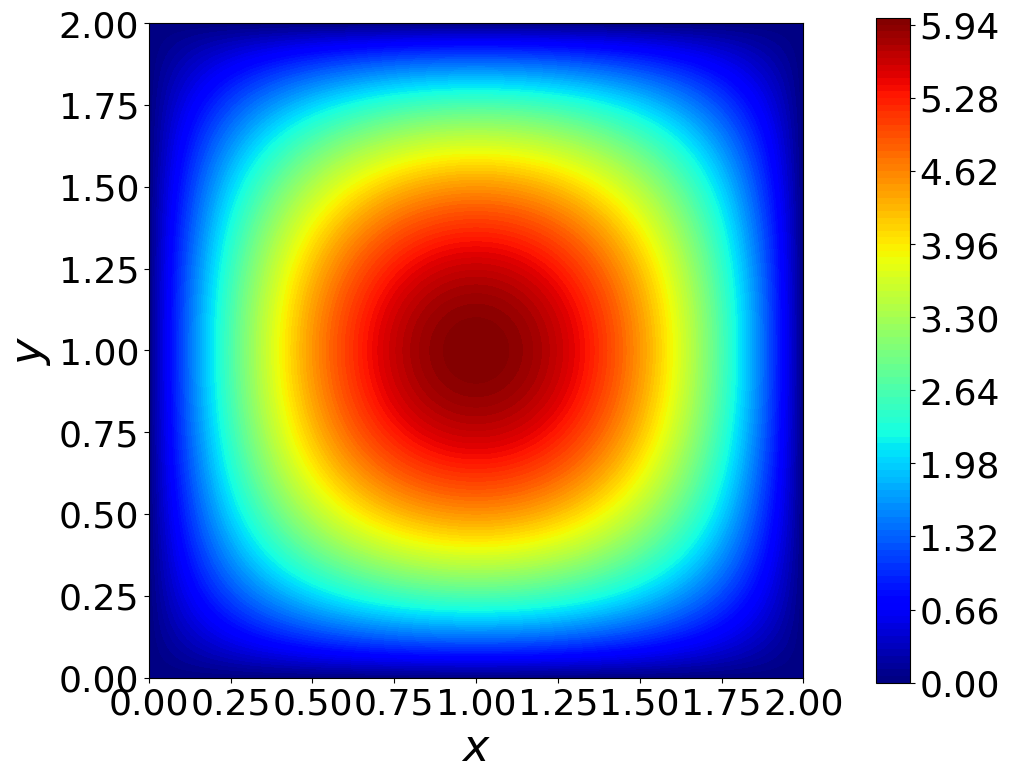

In [21]:
x_test_plot = np.asarray(np.split(X_test[:,0:1].flatten(),len(ytest)))
y_test_plot = np.asarray(np.split(X_test[:,1:2].flatten(),len(ytest)))
u_test_plot = np.asarray(np.split(u_test.flatten(),len(ytest)))
u_pred_plot = np.asarray(np.split(u_pred.flatten(),len(ytest)))


fontsize = 32
labelsize = 26
fig_ext, ax_ext = plt.subplots(constrained_layout=True)
CS_ext = ax_ext.contourf(x_test_plot, y_test_plot, u_test_plot, 100, cmap='jet', origin='lower')
cbar = fig_ext.colorbar(CS_ext, shrink=0.67)
cbar.ax.tick_params(labelsize = labelsize)
ax_ext.locator_params(nbins=8)
ax_ext.set_xlabel('$x$' , fontsize = fontsize)
ax_ext.set_ylabel('$y$' , fontsize = fontsize)
plt.tick_params( labelsize = labelsize)
ax_ext.set_aspect(1)
#fig.tight_layout()
fig_ext.set_size_inches(w=10,h=10)

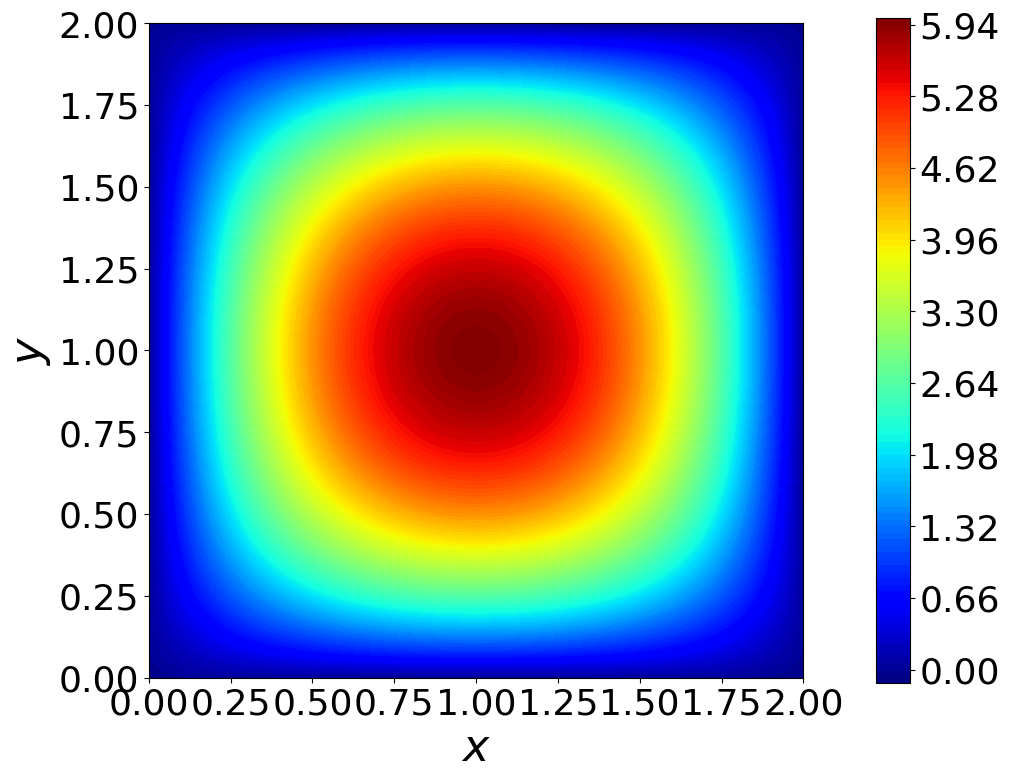

In [22]:
fig_pred, ax_pred = plt.subplots(constrained_layout=True)
CS_pred = ax_pred.contourf(x_test_plot, y_test_plot, u_pred_plot, 100, cmap='jet', origin='lower')
cbar = fig_pred.colorbar(CS_pred, shrink=0.67)
cbar.ax.tick_params(labelsize = labelsize)
ax_pred.locator_params(nbins=8)
ax_pred.set_xlabel('$x$' , fontsize = fontsize)
ax_pred.set_ylabel('$y$' , fontsize = fontsize)
plt.tick_params( labelsize = labelsize)
ax_pred.set_aspect(1)
fig.tight_layout()
fig_pred.set_size_inches(w=10,h=10)

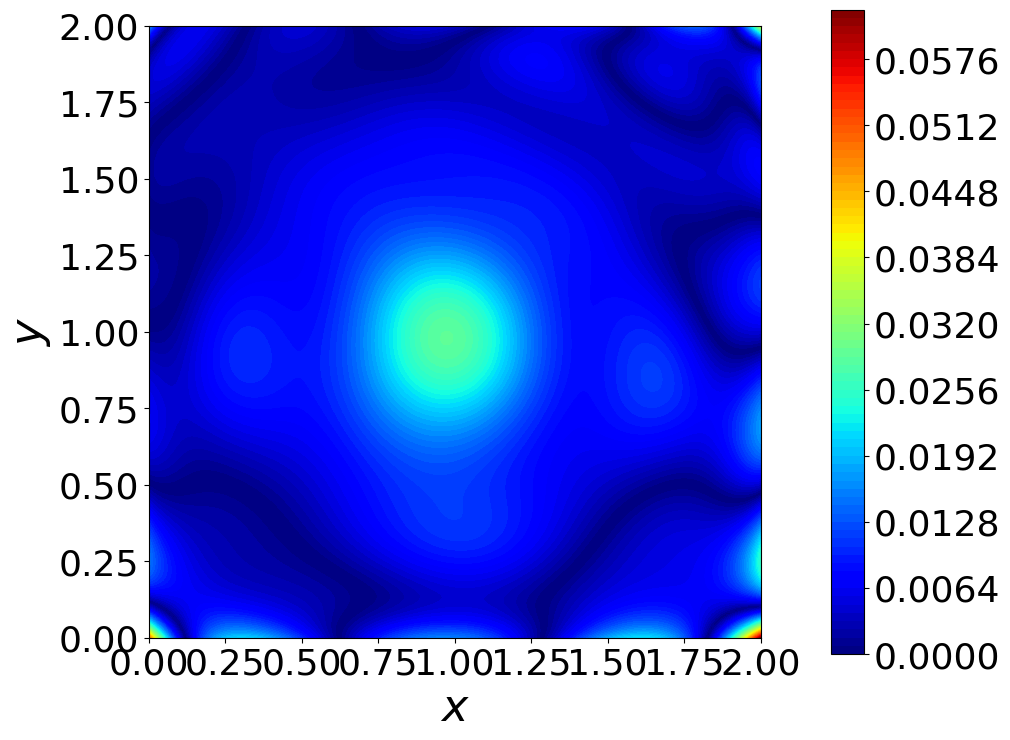

In [23]:
fig_err, ax_err = plt.subplots(constrained_layout=True)
CS_err = ax_err.contourf(x_test_plot, y_test_plot, abs(u_test_plot - u_pred_plot), 100, cmap='jet', origin='lower')
cbar = fig_err.colorbar(CS_err, shrink=0.65, format="%.4f")
cbar.ax.tick_params(labelsize = labelsize)
ax_err.locator_params(nbins=8)
ax_err.set_xlabel('$x$' , fontsize = fontsize)
ax_err.set_ylabel('$y$' , fontsize = fontsize)
plt.tick_params( labelsize = labelsize)
ax_err.set_aspect(1)
#fig.tight_layout()
fig_err.set_size_inches(w=10,h=10)
#plt.savefig(''.join(['Poisson2D_',scheme,'_PntErr','.png']))

In [ ]:
torch.zeros_like